# Preparation

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys
import matplotlib.pyplot as plt

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import ReducedRegressionForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [3]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
listOfRegressors = [SVR(),DecisionTreeRegressor(),KNeighborsRegressor(10),LinearRegression(),
                    RandomForestRegressor(),ExtraTreesRegressor(),
                    XGBRegressor(),LGBMRegressor(),CatBoostRegressor(iterations=100,silent=True)]

## Dataset

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x180e3669908>)

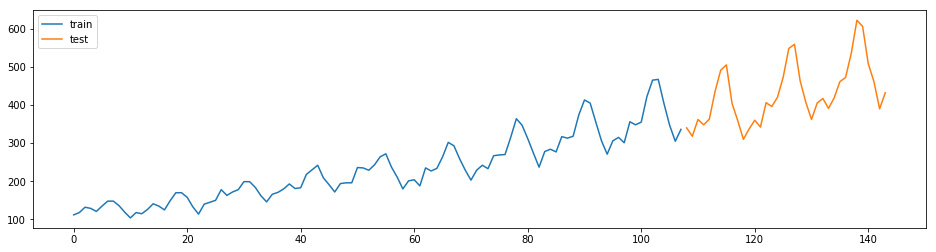

In [5]:
from sktime.datasets import load_airline
airline = load_airline()
train, test = temporal_train_test_split(airline, test_size=36)
plot_ys(train,test,labels=['train','test'])

## Forecasting Window

* Decide on __FORECASTING_HORIZON__ ; i.e. number of steps ahead for the prediction

In [6]:
FH = 36
fh = np.arange(1,FH+1)

# Reduction

A common approach is to solve forecasting via regression. We typically do this as follows: we first split the training series into fixed-length windows and stack them on top of each other. This gives us a matrix of lagged values in a tabular format, and thus allows us to apply any tabular regression algorithm. To generate forecasts, there are multiple strategies, a common one is the recursive strategy. Here we use the last window as input to the fitted regressor to generate the first step ahead forecast. To make multi-step ahead forecasts, we can update the last window recursively with the previously forecasted values.

* https://arxiv.org/pdf/2005.08067.pdf
* https://github.com/alan-turing-institute/sktime/blob/master/examples/01_forecasting.ipynb

# Custom Reduction using sklearn

### Prepare Dataset

* Decide on __WINDOW_LENGTH__ ; i.e. how many predictions to leverage before making a new prediction 

In [7]:
WINDOW_LENGTH = 10

In [8]:
features = []
target = []
for i in range(len(airline)-WINDOW_LENGTH):
    features.append(airline[i:i+WINDOW_LENGTH])
    target.append(airline[i+WINDOW_LENGTH])
features = np.array(features)
target = np.array(target)

In [9]:
airline[:10]

0    112.0
1    118.0
2    132.0
3    129.0
4    121.0
5    135.0
6    148.0
7    148.0
8    136.0
9    119.0
Name: Airline, dtype: float64

In [10]:
features

array([[112., 118., 132., ..., 148., 136., 119.],
       [118., 132., 129., ..., 136., 119., 104.],
       [132., 129., 121., ..., 119., 104., 118.],
       ...,
       [405., 417., 391., ..., 622., 606., 508.],
       [417., 391., 419., ..., 606., 508., 461.],
       [391., 419., 461., ..., 508., 461., 390.]])

In [11]:
target

array([104., 118., 115., 126., 141., 135., 125., 149., 170., 170., 158.,
       133., 114., 140., 145., 150., 178., 163., 172., 178., 199., 199.,
       184., 162., 146., 166., 171., 180., 193., 181., 183., 218., 230.,
       242., 209., 191., 172., 194., 196., 196., 236., 235., 229., 243.,
       264., 272., 237., 211., 180., 201., 204., 188., 235., 227., 234.,
       264., 302., 293., 259., 229., 203., 229., 242., 233., 267., 269.,
       270., 315., 364., 347., 312., 274., 237., 278., 284., 277., 317.,
       313., 318., 374., 413., 405., 355., 306., 271., 306., 315., 301.,
       356., 348., 355., 422., 465., 467., 404., 347., 305., 336., 340.,
       318., 362., 348., 363., 435., 491., 505., 404., 359., 310., 337.,
       360., 342., 406., 396., 420., 472., 548., 559., 463., 407., 362.,
       405., 417., 391., 419., 461., 472., 535., 622., 606., 508., 461.,
       390., 432.])

In [12]:
features.shape

(134, 10)

### Train Test Split

In [13]:
TRAIN_RATIO = 0.8
train_shape = int(features.shape[0] * 0.8)

In [14]:
features_train = features[:train_shape]
target_train = target[:train_shape]
features_test = features[train_shape:]
target_test = target[train_shape:]

In [15]:
[x.shape for x in [features_train,features_test,target_train,target_test]]

[(107, 10), (27, 10), (107,), (27,)]

### Train Regressor

In [16]:
regr = RandomForestRegressor()
regr.fit(features_train,target_train)
y_preds = regr.predict(features_test)

In [17]:
size1 = target_train.shape[0]
size2 = target_test.shape[0]

y_train = pd.Series(target_train)
y_test = pd.Series(target_test,index=range(size1,size1 + size2))
y_pred = pd.Series(y_preds,index=range(size1,size1 + size2))

In [18]:
smape_loss(y_test,y_pred)

0.0989280918338179

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x180e57917f0>)

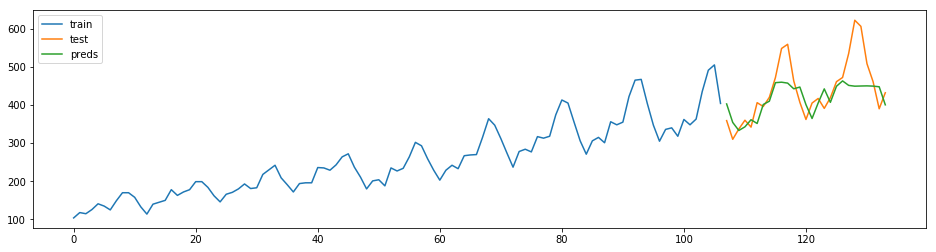

In [19]:
plot_ys(y_train,y_test,y_pred,labels=['train','test','preds'])

> We actually don't make a multi-step-ahead forecast up to the 36th step ahead.<br> 
Instead, we make __36 single-step-ahead forecasts always using the most recent data__. <br>
But that's a solution to a different learning task!

### Recursive predictions

In [20]:
list_of_predictions = []
feature_vector = list(features_test[0])

In [21]:
for x in range(features_test.shape[0]):
    print(f'Prediction {x}')
    print(f'{feature_vector}')
    prediction = regr.predict(np.array(feature_vector).reshape(1,-1))[0]
    print(f'Predicted Value : {prediction}')
    feature_vector.pop(0)
    feature_vector.append(prediction)
    list_of_predictions.append(prediction)
    print(f'New feature vector : {feature_vector}')
    print()

Prediction 0
[336.0, 340.0, 318.0, 362.0, 348.0, 363.0, 435.0, 491.0, 505.0, 404.0]
Predicted Value : 402.7
New feature vector : [340.0, 318.0, 362.0, 348.0, 363.0, 435.0, 491.0, 505.0, 404.0, 402.7]

Prediction 1
[340.0, 318.0, 362.0, 348.0, 363.0, 435.0, 491.0, 505.0, 404.0, 402.7]
Predicted Value : 403.98
New feature vector : [318.0, 362.0, 348.0, 363.0, 435.0, 491.0, 505.0, 404.0, 402.7, 403.98]

Prediction 2
[318.0, 362.0, 348.0, 363.0, 435.0, 491.0, 505.0, 404.0, 402.7, 403.98]
Predicted Value : 395.58
New feature vector : [362.0, 348.0, 363.0, 435.0, 491.0, 505.0, 404.0, 402.7, 403.98, 395.58]

Prediction 3
[362.0, 348.0, 363.0, 435.0, 491.0, 505.0, 404.0, 402.7, 403.98, 395.58]
Predicted Value : 402.96
New feature vector : [348.0, 363.0, 435.0, 491.0, 505.0, 404.0, 402.7, 403.98, 395.58, 402.96]

Prediction 4
[348.0, 363.0, 435.0, 491.0, 505.0, 404.0, 402.7, 403.98, 395.58, 402.96]
Predicted Value : 403.27
New feature vector : [363.0, 435.0, 491.0, 505.0, 404.0, 402.7, 403.98, 

In [22]:
len(list_of_predictions)

27

In [23]:
y_pred_recursive = pd.Series(list_of_predictions,index=range(size1,size1 + size2))

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x180e582bda0>)

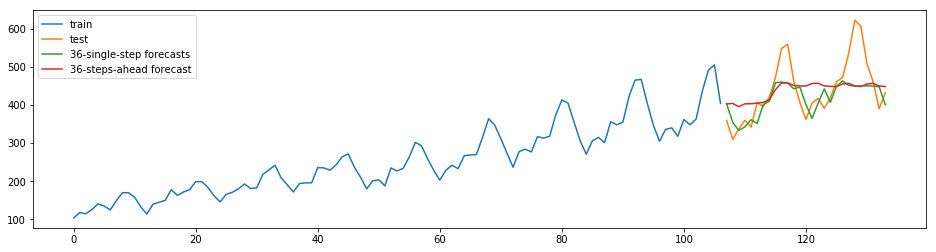

In [24]:
plot_ys(y_train,y_test,y_pred,y_pred_recursive,labels=['train','test','36-single-step forecasts','36-steps-ahead forecast'])

> 36-steps-ahead forecast : Start with the first feature vector (for timestep = 1) and make a forecast. Then append this forecast to the existing feature vector and get rid of the oldest value available in the feature vector - so its size remains constant

# Reduction through sktime API

### Train Test Split with temporal_train_test_split

In [25]:
TEST_SIZE = FH = 36
fh = np.arange(1,FH+1)
train, test = temporal_train_test_split(airline, test_size = TEST_SIZE)
[x.shape for x in [train, test]]

[(108,), (36,)]

### ReducedRegressionForecaster

In [26]:
regressor = RandomForestRegressor(n_estimators=500)
rdcd_regr = ReducedRegressionForecaster(regressor, window_length=WINDOW_LENGTH)
rdcd_regr.fit(train)

RecursiveRegressionForecaster(regressor=RandomForestRegressor(n_estimators=500))

In [27]:
y_pred = rdcd_regr.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x180e5945080>)

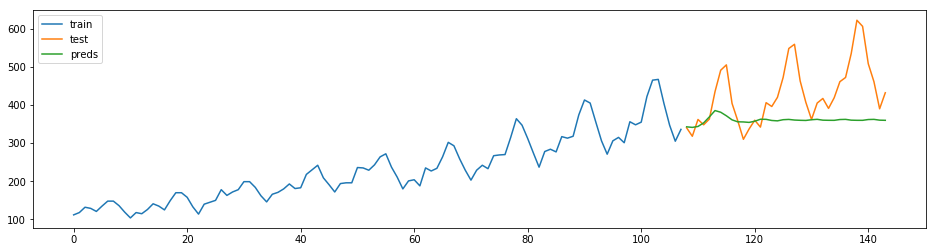

In [28]:
plot_ys(train,test,y_pred,labels=['train','test','preds'])

### Evaluate Different Regressors

SVR : 0.5467
DecisionTreeRegressor : 0.3987
KNeighborsRegressor : 0.2059
LinearRegression : 0.1364
RandomForestRegressor : 0.1509
ExtraTreesRegressor : 0.1831
[13:01:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor : 0.1866
LGBMRegressor : 0.1725
CatBoostRegressor : 0.1826


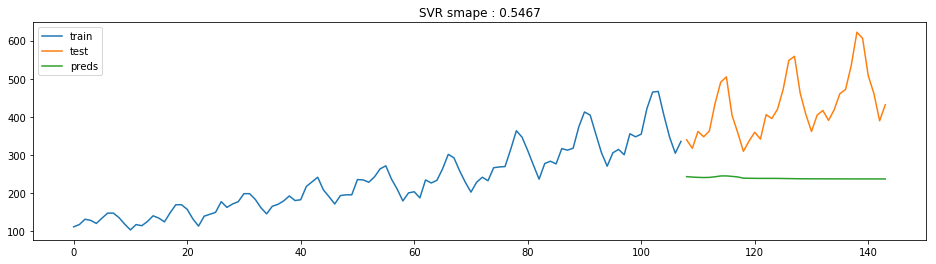

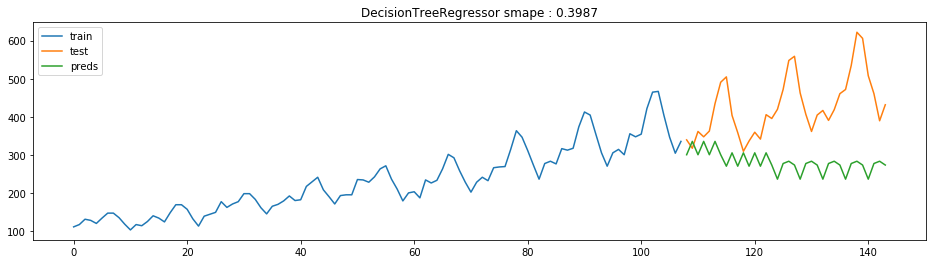

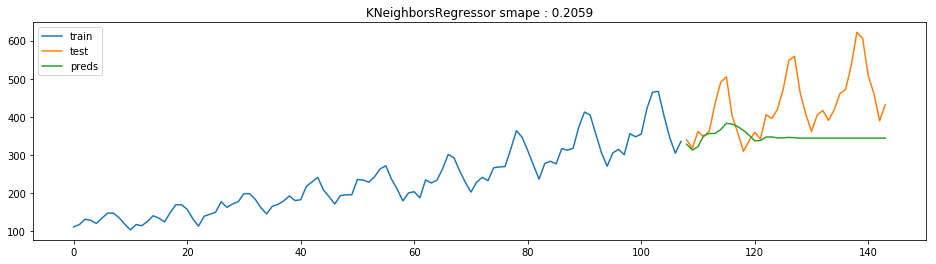

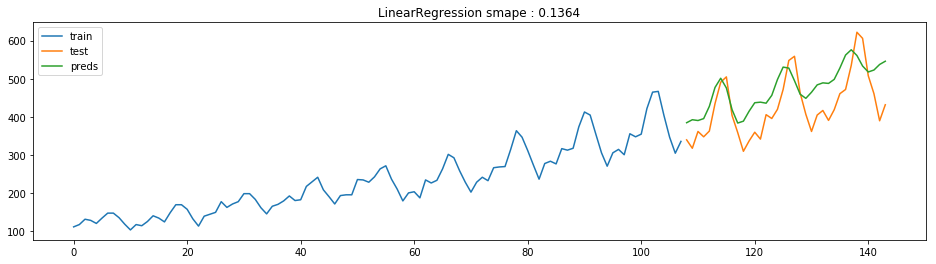

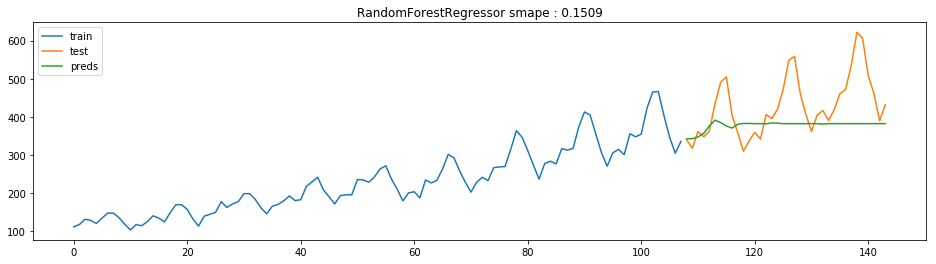

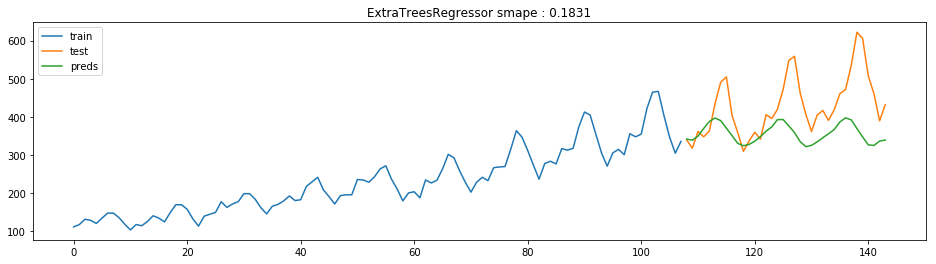

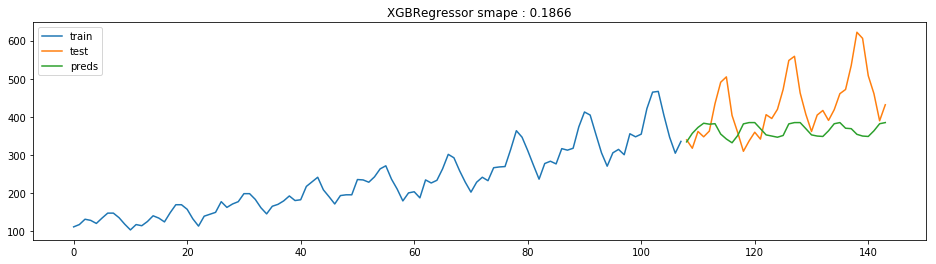

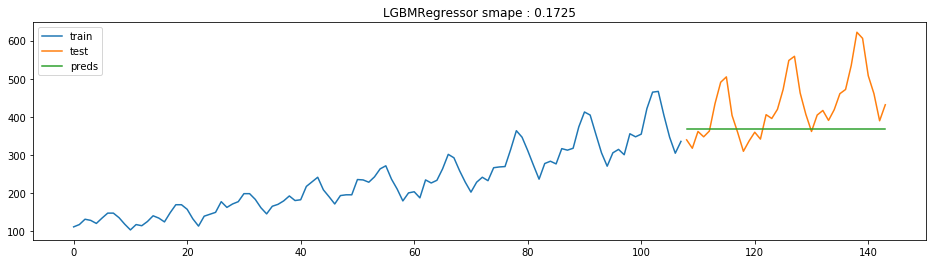

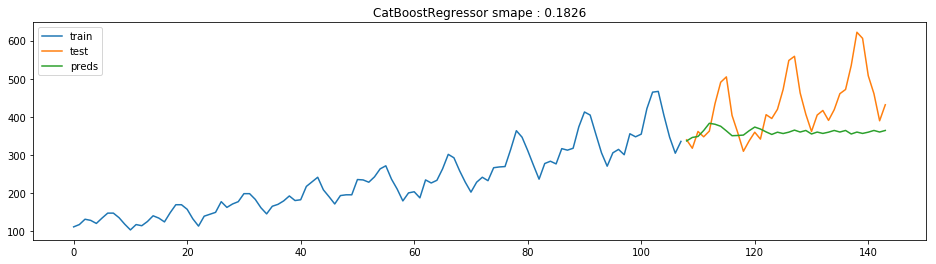

In [29]:
results = {}
for r in listOfRegressors:
    rgr = r
    rdcd_regr = ReducedRegressionForecaster(rgr, window_length=10)
    rdcd_regr.fit(train)
    y_pred = rdcd_regr.predict(fh)
    results[r.__class__.__name__] = smape_loss(test,y_pred)
    plot_ys(train,test,y_pred,labels=['train','test','preds'])
    plt.title(f'{r.__class__.__name__} smape : {round(smape_loss(test,y_pred),4)}')
    print(f'{r.__class__.__name__} : {round(smape_loss(test,y_pred),4)}')

In [30]:
pd.DataFrame()\
    .from_dict(results, orient='index')\
    .rename_axis('Regressor')\
    .rename(columns={0: 'smape_loss'})\
    .sort_values(by='smape_loss', ascending=True)\
    .reset_index()

,Regressor,smape_loss
0,LinearRegression,0.136406
1,RandomForestRegressor,0.150938
2,LGBMRegressor,0.172497
3,CatBoostRegressor,0.182624
4,ExtraTreesRegressor,0.183141
5,XGBRegressor,0.186640
6,KNeighborsRegressor,0.205914
7,DecisionTreeRegressor,0.398656
8,SVR,0.546669
